In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

c:\Users\thj05\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the dataset and perform initial exploration to understand its structure and characteristics.

In [2]:
df = pd.read_csv('E:/data mining/project/dataset/calories.csv')
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [3]:
df.shape

(15000, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [5]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [6]:
# Check for missing values in each column
df.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [7]:
# User_ID is a unique identifier and does not contribute to the regression task
df=df.drop(columns='User_ID')
df.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,female,27,154.0,58.0,10.0,81.0,39.8,35.0


## Data visualisation


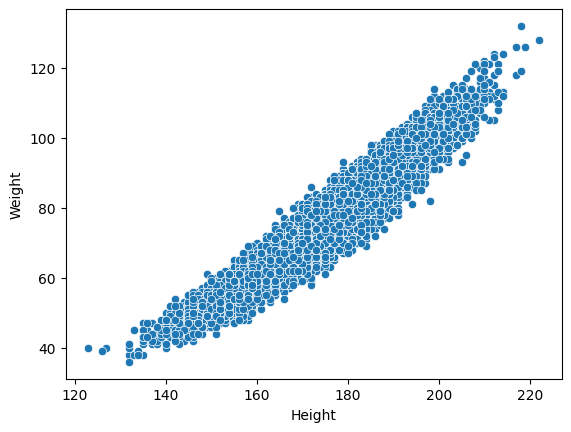

In [8]:
#Scatterplot of height and weight
sns.scatterplot(x='Height', y='Weight', data=df)
plt.savefig('E://data mining//project//figures//Height and Weight scatter_plots.png')
plt.show()

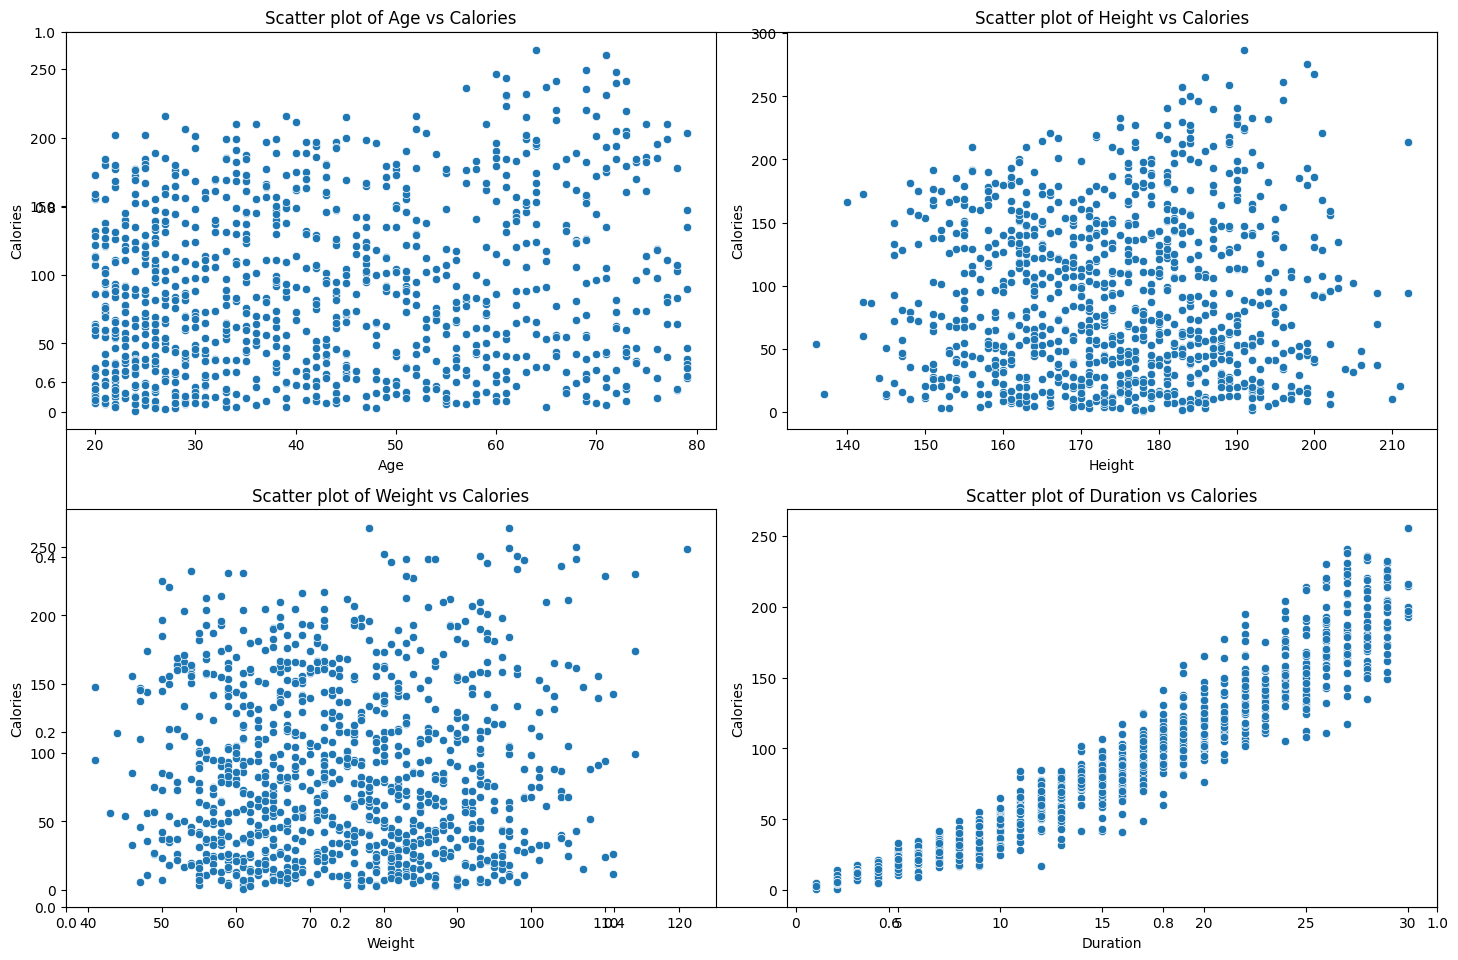

In [9]:
# Select 'Age', 'Height', 'Weight', 'Duration' as features to study the scatterplot distribution of Calories
features = ['Age', 'Height', 'Weight', 'Duration']

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    x = df.sample(1000)
    sns.scatterplot(x=col, y='Calories', data=x)
    plt.title(f'Scatter plot of {col} vs Calories')
    plt.xlabel(col)
plt.savefig('E://data mining//project//figures//scatter_plots with Calories.png')
plt.tight_layout()
plt.show()

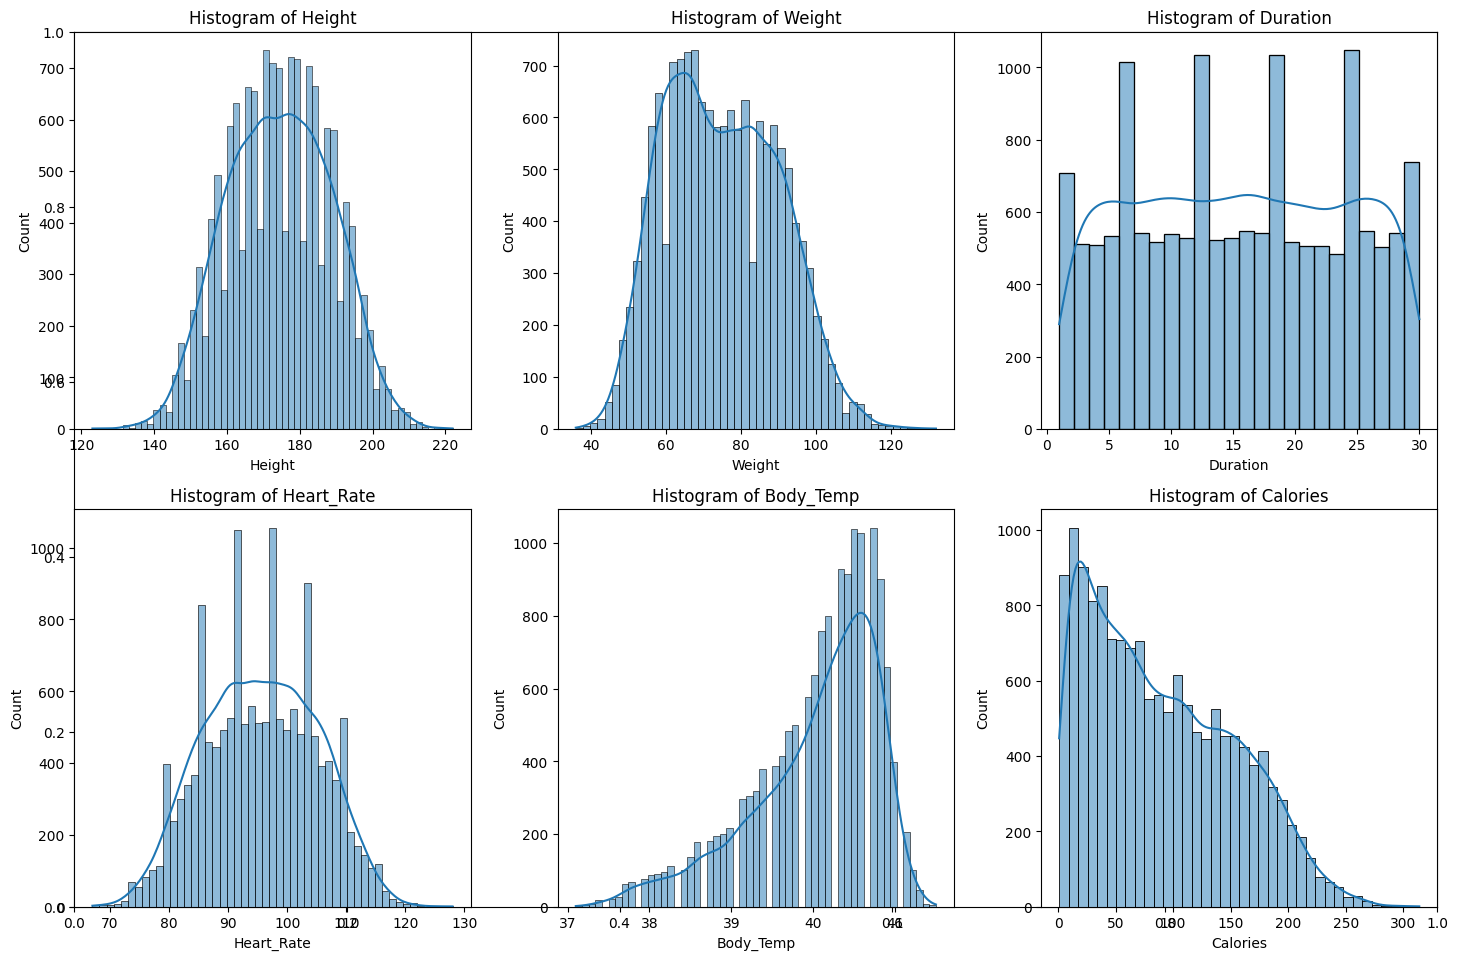

In [10]:
# Plotting histograms containing kernel density estimation (KDE) curves
features = df.select_dtypes(include='float').columns

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col],kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
plt.savefig('E://data mining//project//figures//hist.png')
plt.tight_layout()
plt.show()

In [11]:
df['Gender']=df['Gender'].map({'male':0,'female':1})
df.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,1,27,154.0,58.0,10.0,81.0,39.8,35.0


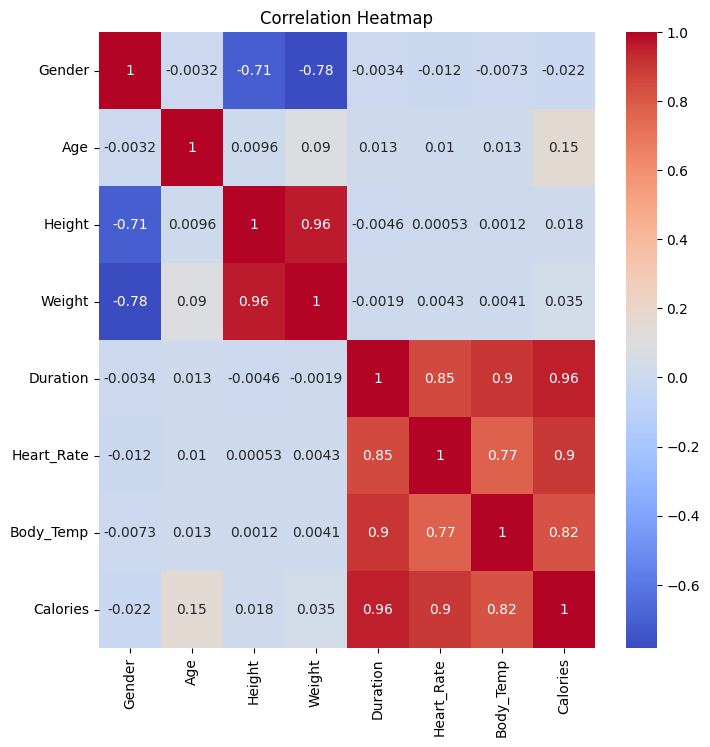

In [12]:
# correlation matrix heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig('E://data mining//project//figures//Correlation Heatmap.png')
plt.show()

In [13]:
# Divide the dataset
X = df.drop(['Calories'], axis=1)
y = df['Calories']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, X_scaled.shape, y.shape

((12000, 7), (3000, 7), (15000, 7), (15000,))

## Model building Hyperparameter tuning Cross-validation

In [14]:
# Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Neural Network': MLPRegressor(max_iter=2000, random_state=42)
}

# Hyperparameters
tuned_params = {
    'Ridge Regression': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5], 'learning_rate': [0.01, 0.1, 0.3]},
    'Neural Network': {'hidden_layer_sizes': [(64, 32), (128, 64), (100,)], 'learning_rate_init': [0.001, 0.01]}
}

# Fit and evaluate
fitted_models = {}
results = {}

for name, model in models.items():
    if name in tuned_params:
        grid = GridSearchCV(model, tuned_params[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"{name} Best Parameters: {grid.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train, y_train)

    fitted_models[name] = best_model
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    cv_mse = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    cv_r2 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2').mean()

    results[name] = {'MSE': mse, 'RMSE': rmse, 'R²': r2, 'CV MSE': cv_mse, 'CV R²': cv_r2}

results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

Ridge Regression Best Parameters: {'alpha': 0.1}
Lasso Best Parameters: {'alpha': 0.1}
Random Forest Best Parameters: {'max_depth': None, 'n_estimators': 200}
XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Neural Network Best Parameters: {'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001}

Model Performance Comparison:
                          MSE       RMSE        R²      CV MSE     CV R²
Linear Regression  131.995746  11.488940  0.967294  127.309067  0.967028
Ridge Regression   131.996351  11.488966  0.967294  127.309099  0.967028
Lasso              133.082123  11.536123  0.967025  127.981602  0.966857
Random Forest        6.981431   2.642240  0.998270    9.371896  0.997580
XGBoost              2.767508   1.663583  0.999314    3.487499  0.999100
Neural Network       0.216959   0.465788  0.999946    0.228622  0.999888


# Comparisons between different models and visualisation of feature significance

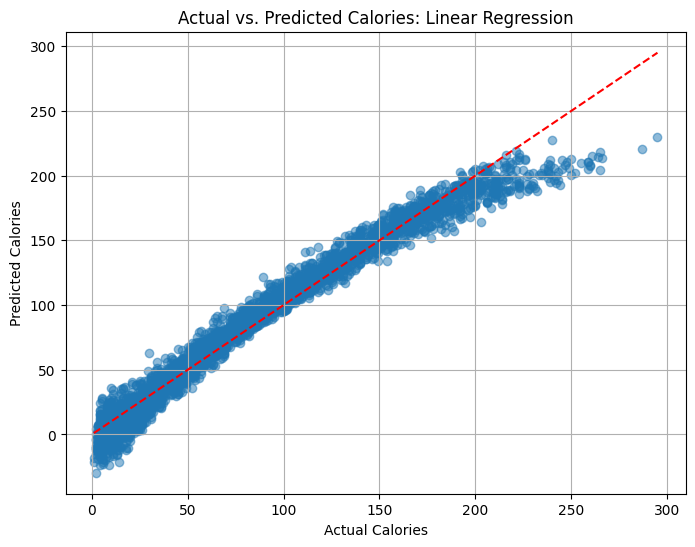

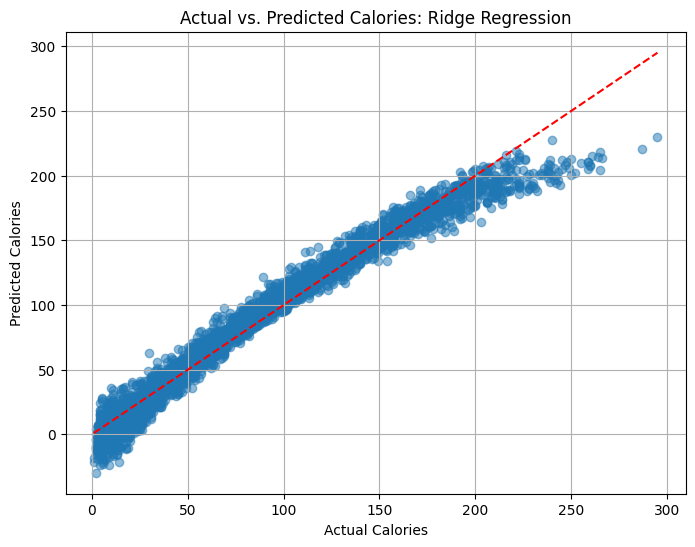

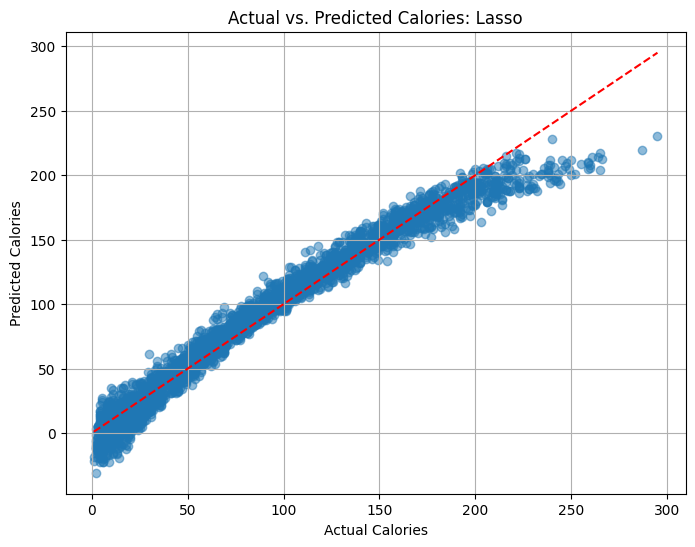

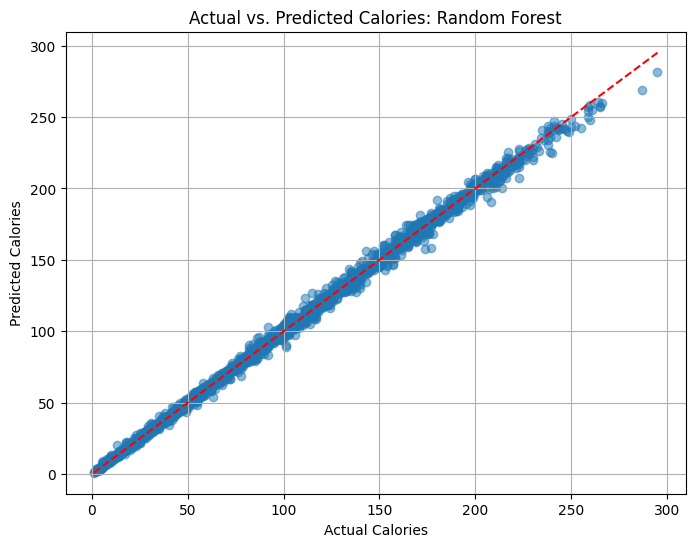

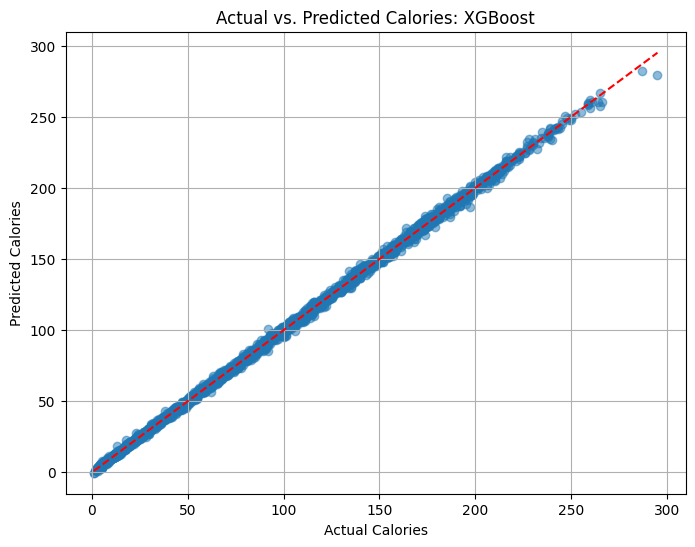

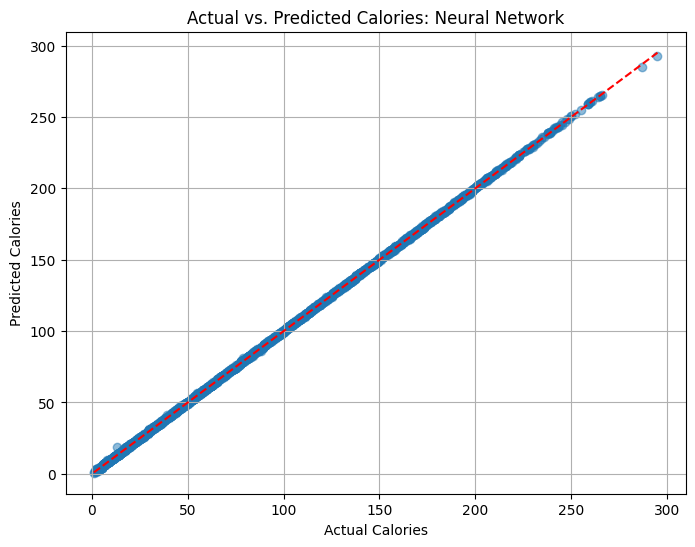

In [15]:
# Plot actual vs predicted
for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.title(f'Actual vs. Predicted Calories: {name}')
    plt.grid(True)
    plt.savefig(f'E://data mining//project//figures//actual_vs_predicted_{name.lower().replace(" ", "_")}.png')
    plt.show()

Neural networks and random forests significantly outperform other models, linear class models work less well

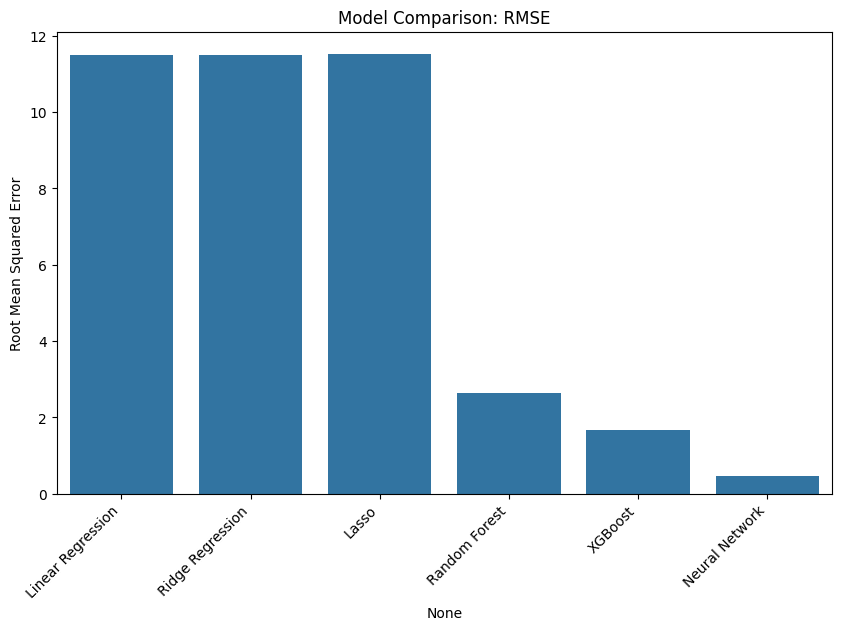

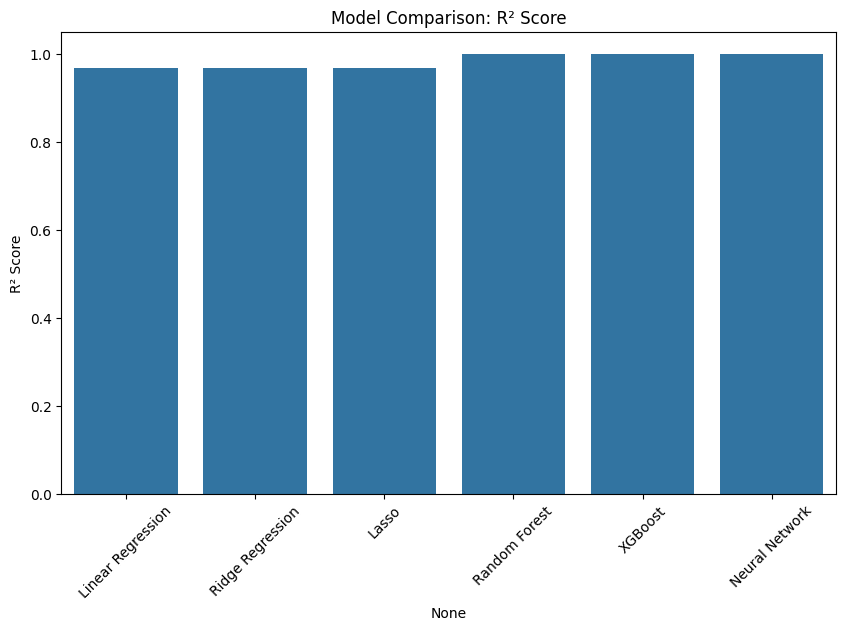

In [16]:
# RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.title('Model Comparison: RMSE')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Root Mean Squared Error')
plt.savefig('E://data mining//project//figures//Model_Comparison_RMSE.png', bbox_inches='tight')
plt.show()

# R² Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['R²'])
plt.title('Model Comparison: R² Score')
plt.xticks(rotation=45)
plt.ylabel('R² Score')
plt.savefig('E://data mining//project//figures//Model_Comparison_R²_Score.png')
plt.show()

Neural networks, Random forests, XGBoost, all have higher R^2


Generating SHAP values for Random Forest...


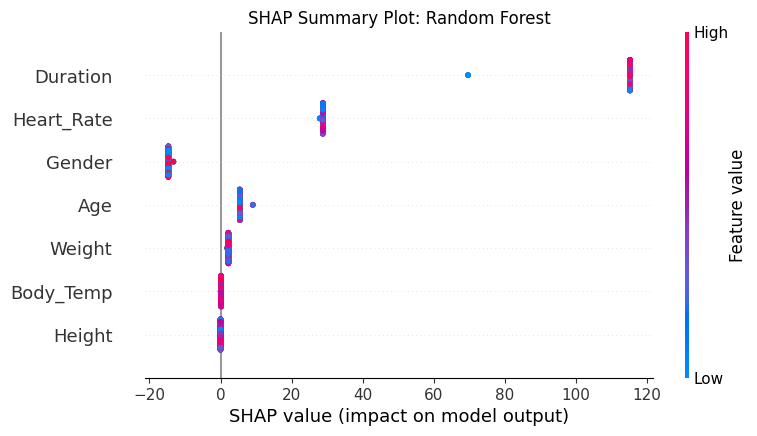


Generating SHAP values for XGBoost...


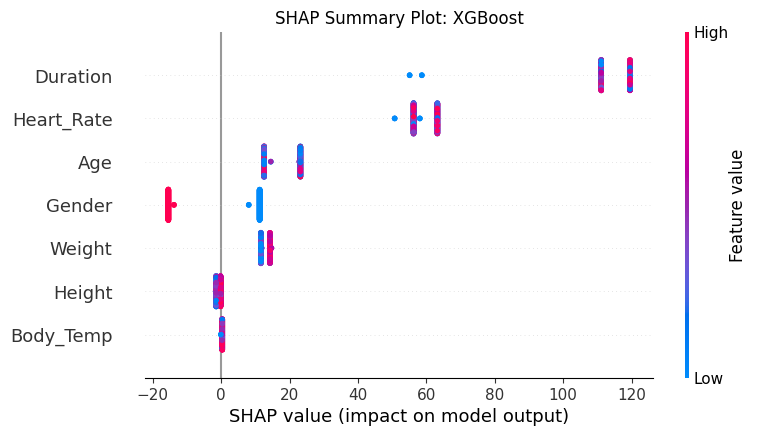

In [19]:
# SHAP explanation for Random Forest and XGBoost
X_df = pd.DataFrame(X, columns=df.drop('Calories', axis=1).columns)

# For supported tree models, use the TreeExplainer
for name in ['Random Forest', 'XGBoost']:
    print(f"\nGenerating SHAP values for {name}...")

    model = fitted_models[name]  # of trained models (no packaging required)

    # Create SHAP TreeExplainer
    explainer = shap.TreeExplainer(model)
    
    # Only the first 500 samples interpreted to speed up (adjustable)
    X_sample = X_df.sample(500, random_state=42)
    
    # Calculate the SHAP value
    shap_values = explainer.shap_values(X_sample)
    
    # Plotting the SHAP summary
    shap.summary_plot(shap_values, X_sample, feature_names=X_df.columns, show=False)
    plt.title(f"SHAP Summary Plot: {name}")
    plt.savefig(f'E://data mining//project//figures//SHAP_summary_plot_{name}.png')
    plt.show()



Generating SHAP values for Neural Network...


ExactExplainer explainer: 15001it [04:46, 51.64it/s]                           


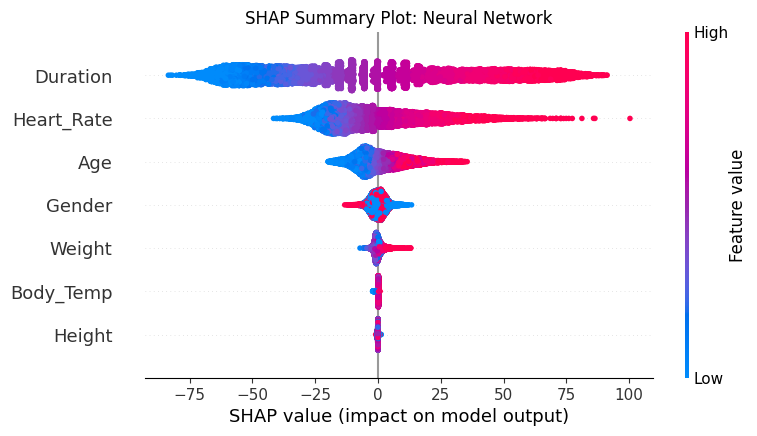

In [18]:
# SHAP explanation for Neural Network using general Explainer
print("\nGenerating SHAP values for Neural Network...")
model = fitted_models['Neural Network']

def predict_fn(x):
    x_scaled = scaler.transform(x)
    return model.predict(x_scaled)

explainer = shap.Explainer(predict_fn, X_df)
shap_values = explainer(X_df)
shap.summary_plot(shap_values, X_df, feature_names=X_df.columns, show=False)
plt.title("SHAP Summary Plot: Neural Network")
plt.savefig('E://data mining//project//figures//SHAP_summary_plot_Neural_Network.png')
plt.show()

Duration and Heart_Rate contribute the most to the prediction.